# 3D pointcould reconstruction from a stereo setup

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from calibration import match_image_points
from correspondence import extract_window
from visualization import visualize_charuco_detection, visualize_epipolar_lines

In [2]:
TARGET_SIZE = (1392, 1044)

## Stereo setup

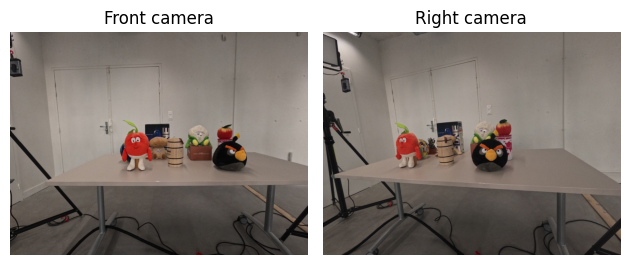

In [3]:
img_front = cv.imread("forall/front/GOPR0158.JPG")
img_right = cv.imread("forall/right/GOPR0930.JPG")

img_front = cv.resize(img_front, TARGET_SIZE)
img_right = cv.resize(img_right, TARGET_SIZE)

fig, axes = plt.subplots(1, 2)

# Display the images in the subplots
axes[0].imshow(np.flip(img_front, axis=2))
axes[0].set_title('Front camera')

axes[1].imshow(np.flip(img_right, axis=2))
axes[1].set_title('Right camera')

# Hide the axes
for ax in axes:
    ax.axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()

## Camera calibration

In [4]:
from calibration import detect_dictionary

img_with_charuco = cv.imread("forall/front/GOPR0155.JPG")
detect_dictionary(img_with_charuco)
dictionary = cv.aruco.getPredefinedDictionary(cv.aruco.DICT_6X6_50)

Detected 1 markers for DICT_4X4_1000
Detected 17 markers for DICT_6X6_50
Detected 17 markers for DICT_6X6_100
Detected 17 markers for DICT_6X6_250
Detected 17 markers for DICT_6X6_1000


In [5]:
SQUARE_LENGTH = 0.0525
MARKER_LENGTH = 0.0310

SQUARE_X = 5
SQUARE_Y = 7

size = (SQUARE_X, SQUARE_Y)
board = cv.aruco.CharucoBoard(size, SQUARE_LENGTH, MARKER_LENGTH, dictionary)

When detecting markers for ChArUco boards, and especially when using homography, 
it is recommended to disable the corner refinement of markers. 

The reason of this is that, due to the proximity of the chessboard squares, 
the subpixel process can produce important deviations in the corner positions 
and these deviations are propagated to the ChArUco corner interpolation, 
producing poor results.

In [6]:
charuco_params = cv.aruco.CharucoParameters()
charuco_params.tryRefineMarkers = False
detector_params = cv.aruco.DetectorParameters()
detector = cv.aruco.CharucoDetector(board, charuco_params, detector_params)

### Estimate intrinsic parameters

In [7]:
front_ids = range(155, 158)
front_paths = list(map(lambda id: f"forall/front/GOPR{id:04d}.JPG", front_ids))

l_obj_points, l_img_points = match_image_points(front_paths, detector, TARGET_SIZE)
ret, l_mtx, l_dist, _, _ = cv.calibrateCamera(
    l_obj_points, l_img_points, TARGET_SIZE, None, None)

print("---- Result ----")
print(f"Intrinsic parameters:")
print(l_mtx)
print(f"Distortion coefficients:")
print(l_dist)
print(f"Reprojection error:")
print(ret)

[>] Detected 24 ChArUco corners in GOPR0155.JPG
[>] Detected 24 ChArUco corners in GOPR0156.JPG
[>] Detected 24 ChArUco corners in GOPR0157.JPG
---- Result ----
Intrinsic parameters:
[[513.41529862   0.         731.9463788 ]
 [  0.         514.43923784 531.28411495]
 [  0.           0.           1.        ]]
Distortion coefficients:
[[ 0.01211665 -0.03299335  0.00202433  0.00629915  0.02382633]]
Reprojection error:
0.24169964280244904


In [8]:
right_ids = range(927, 930)
right_paths = list(map(lambda id: f"forall/right/GOPR{id:04d}.JPG", right_ids))

r_obj_points, r_img_points = match_image_points(right_paths, detector, TARGET_SIZE)
ret, r_mtx, r_dist, _, _ = cv.calibrateCamera(
    r_obj_points, r_img_points, TARGET_SIZE, None, None)

print("---- Result ----")
print(f"Intrinsic parameters:")
print(r_mtx)
print(f"Distortion coefficients:")
print(r_dist)
print(f"Reprojection error:")
print(ret)

[>] Detected 24 ChArUco corners in GOPR0927.JPG
[>] Detected 24 ChArUco corners in GOPR0928.JPG
[>] Detected 24 ChArUco corners in GOPR0929.JPG
---- Result ----
Intrinsic parameters:
[[620.5291967    0.         759.48782185]
 [  0.         610.55868533 530.87390632]
 [  0.           0.           1.        ]]
Distortion coefficients:
[[-0.05895355  0.0751742   0.00566541  0.00141816 -0.02947563]]
Reprojection error:
0.2597073283335436


## Stereo calibration

Suppose we have two cameras, left and right, the goal is to find a `3x3` 
$R^{(r)}$ matrix and a `3x1` $\boldsymbol{t}^{(r)}$ vector such that:

$$
\begin{bmatrix}x^{(l)} \\ y^{(l)} \\ z^{(l)} \\ 1\end{bmatrix} = \begin{bmatrix}
R^{(r)} & \boldsymbol{t}^{(r)} \\ \boldsymbol{0} & 1\end{bmatrix} 
\begin{bmatrix}x^{(r)} \\ y^{(r)} \\ z^{(r)} \\ 1\end{bmatrix}
$$

If $R^{(r)}$ and $\boldsymbol{t}^{(r)}$ satisfy the above condition:
- $R^{(r)}$ will be the orientation of the **left** camera in the **right** 
camera's coordinate frame.
- $\boldsymbol{t}^{(r)}$ will be the position of the **right** camera in the 
**left** camera's coordinate frame.

In particular, the rows of $R^{(r)}$ is the coordinates of the left camera's 
$\hat{i}$, $\hat{j}$, and $\hat{k}$ vectors in the the right camera's coordinate 
frame.

Suppose $\boldsymbol{t}^{(r)} = (t_x,\ t_y,\ t_z)$, we define 
a skew matrix $T_X^{(r)} = \begin{bmatrix} 0 & -t_z & t_y \\ t_z & 0 & -t_x \\
-t_y & t_x & 0\end{bmatrix}$

If we let $E^{(r)} = T_X^{(r)}R^{(r)}$, we have a constraint for pairs of
3D correspondences:

$$
\begin{bmatrix}x^{(l)} & y^{(l)} & z^{(l)}\end{bmatrix}E^{(r)}
\begin{bmatrix}x^{(r)} \\ y^{(r)} \\ z^{(r)}\end{bmatrix} = 0
$$

To convert this contraint for using with image coordinates, we define the
fundamental matrix $F^{(r)} = \mathrm{inv}(K^{(l)})^T E^{(r)} \mathrm{inv}(K^{(r)})$

Now we obtain a new constraint in terms of image coordinates:

$$
\begin{bmatrix}u^{(l)} & v^{(l)} & 1\end{bmatrix}F^{(r)}
\begin{bmatrix}u^{(r)} \\ v^{(r)} \\ 1\end{bmatrix} = 0
$$

We can estimate this $F^{(r)}$ matrix with at least 8 pairs of corresponding
image coordinates which we have found with the help of ChArUco boards:

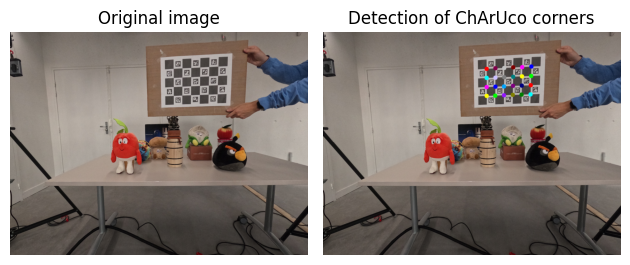

In [20]:
l_img_charuco = cv.imread("forall/front/GOPR0155.JPG")
l_img_charuco = cv.resize(l_img_charuco, TARGET_SIZE)
l_corners, l_ids, _, _ = detector.detectBoard(l_img_charuco)
visualize_charuco_detection(l_img_charuco, l_corners.reshape(-1, 2), radius=10)

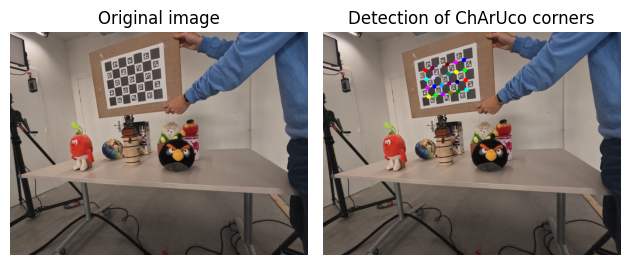

In [21]:
r_img_charuco = cv.imread("forall/right/GOPR0927.JPG")
r_img_charuco = cv.resize(r_img_charuco, TARGET_SIZE)
r_corners, r_ids, _, _ = detector.detectBoard(r_img_charuco)
visualize_charuco_detection(r_img_charuco, r_corners.reshape(-1, 2), radius=10)

### Estimate the funamental matrix

Instead of performing the least square method from scartch, we use `opencv`'s
`findFundamentalMat(p1, p2, ...)` function.

Here, $p_1$ and $p_2$ are list of floating-point image correspondences. The
function returns a matrix $F$ described by the following equation:

$$
\begin{bmatrix}p_2 & 1\end{bmatrix} F \begin{bmatrix}p_1 \\ 1\end{bmatrix} = 0
$$

Therefore, if we want to find $F^{(r)}$ as described previously:

In [37]:
l_F, _ = cv.findFundamentalMat(l_corners, r_corners, cv.FM_LMEDS)
print("Fundamental matrix for the left image")
print(l_F)

Fundamental matrix for the left image
[[ 1.14887811e-06 -8.42592382e-06  1.08769894e-03]
 [ 7.31780830e-06  9.38810895e-07 -7.06252585e-03]
 [-2.47047991e-03  5.08621081e-03  1.00000000e+00]]


### Recover the right camera's relative pose

Having found $F^{(r)}$, we can work out the essential matrix
$E^{(r)} = K^{(l)^T} F^{(r)} K^{(r)}$

In [23]:
l_E = r_mtx.T @ l_F @ l_mtx
l_E

array([[ 0.29415654, -2.1651779 , -1.27441801],
       [ 1.98533729,  0.24779046, -1.22463644],
       [ 0.94302479,  0.18649221, -0.54754854]])

To recover the $R^{(r)}$ matrix and the translation vector $\boldsymbol{t}^{(r)}$,
we take advantage of the fact that $E^{(r)} = T_X^{(r)}R^{(r)}$.

Here, $E^{(r)}$ is a product of a skew-symmetric matrix and an orthonormal 
matrix. 

Such a matrix can be decomposed with Singular Value Decomposition.

Given a matrix $E$ of size $m \times n$, SVD gives three matrices $U,\ W,\ V^T$
such that $E = UWV^T$.
- $U$ is an $m \times m$ orthogonal matrix containing the eigenvectors of $EE^T$
- $W$ is an $m \times n$ diagonal matrix containing the square roots of the
eigenvalues of both $EE^T$ and $E^TE$
- $V$ is an $n \times n$ orthogonal matrix containing the eigenvectors of $E^TE$

In [24]:
l_U, l_w, l_VT = np.linalg.svd(l_E, full_matrices=False)
l_U @ np.diag(l_w) @ l_VT

array([[ 0.29415654, -2.1651779 , -1.27441801],
       [ 1.98533729,  0.24779046, -1.22463644],
       [ 0.94302479,  0.18649221, -0.54754854]])

Follow procedures explained in [Hartley & Zisserman's book](http://www.robots.ox.ac.uk/~vgg/hzbook/hzbook2/HZepipolar.pdf),
the rotation matrix and the translation vector which made up $E$ are one of the 
followings:
- $[R|\boldsymbol{t}] = [U W V^T\ \ \ |\ U\begin{bmatrix}0 & 0 & +s\end{bmatrix}^T]$
- $[R|\boldsymbol{t}] = [U W V^T\ \ \ |\ U\begin{bmatrix}0 & 0 & -s\end{bmatrix}^T]$
- $[R|\boldsymbol{t}] = [U W^T V^T\ |\ U\begin{bmatrix}0 & 0 & +s\end{bmatrix}^T]$
- $[R|\boldsymbol{t}] = [U W^T V^T\ |\ U\begin{bmatrix}0 & 0 & -s\end{bmatrix}^T]$

Here, $W$ is defined as $\begin{bmatrix}0 & -1 & 0 \\ 1 & 0 & 0 \\ 0 & 0 & 1\end{bmatrix}$,
and $s$ is a positve scaling factor.

To summarize, given $E$ there are two opposite directions which are possible for 
$\boldsymbol{t}$ and two different $R$ which are compatible with this essential 
matrix. 

In total this gives four classes of solutions for the rotation and translation 
between the two camera coordinate systems. 

On top of that, there is also an unknown scaling $s > 0$ for the chosen 
translation direction.

It turns out, however, that only one of the four classes of solutions can be 
realized in practice. Given a pair of corresponding image coordinates, three of 
the solutions will always produce a 3D point which lies behind at least one of 
the two cameras and therefore cannot be seen. 

Only one of the four classes will consistently produce 3D points which are in 
front of both cameras. This must then be the correct solution. 

Still, however, it has an undetermined positive scaling related to the 
translation component.


In [25]:
W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
l_R = l_U @ W @ l_VT
l_t = l_U[:, 2]

print("Rotation matrix:")
print(l_R)
print("Translation vector")
print(l_t)

Rotation matrix:
[[-0.86874206 -0.22381511  0.44180767]
 [ 0.21728932 -0.97386745 -0.06608732]
 [-0.44505346 -0.03858725 -0.89467226]]
Translation vector
[ 0.02815898 -0.43228388  0.9012978 ]


### Calibrate stereo with a single function call

In [39]:
ret, _, _, _, _, l_R, l_t, l_E, l_F = cv.stereoCalibrate(
    l_obj_points, l_img_points, r_img_points, l_mtx, l_dist, r_mtx, r_dist, TARGET_SIZE, flags=cv.CALIB_FIX_INTRINSIC)

print("Fundamental matrix:")
print(l_F)
print("Essential matrix:")
print(l_E)
print("Rotation matrix:")
print(l_R)
print("Euler angles of rotation:")
print(cv.Rodrigues(l_R.T)[0])
print("Translation vector:")
print(l_t)
print("Reprojection error (px):")
print(ret)

Fundamental matrix:
[[ 1.67427614e-07  4.10110470e-06 -2.67845785e-03]
 [ 1.32341578e-07 -5.40467383e-07 -7.49805226e-03]
 [ 1.46433217e-04  5.93631146e-03  1.00000000e+00]]
Essential matrix:
[[-0.00695214 -0.17063075  0.03049513]
 [-0.00540695  0.0221254   0.61181398]
 [-0.02300895 -0.58762877  0.01392678]]
Rotation matrix:
[[ 0.95739926  0.01255173  0.28849455]
 [-0.00220567  0.9993436  -0.03615936]
 [-0.28875905  0.03398262  0.95679851]]
Euler angles of rotation:
[[-0.03558526]
 [-0.29285912]
 [ 0.0074869 ]]
Translation vector:
[[-0.58769589]
 [ 0.02538671]
 [ 0.1716061 ]]
Reprojection error (px):
0.8961183631105857


### Visualize the epipolar lines

We can use `opencv`'s `computeCorrespondEpilines()` to visualize the behavior
of $F^{(r)}$.

For every point in one of the two images of a stereo pair, the function finds 
the equation of the corresponding epipolar line in the other image.

In particular, line $l_i^{(2)}$ in the second image for the point $p_i^{(1)}$
in the first image (when `whichImage` is set to 1) is computed as:

$$l_i^{(2)} = F p_i^{(1)}$$

And vice versa, when `whichImage` is set to 2, $l_i^{(1)}$ is computed from 
$p_i^{(2)}$ as:

$$l_i^{(1)} = F^T p_i^{(2)}$$

Here, we have obtained $F^{(r)}$, which means $p_i^{(1)}$ corespond to 
`r_corners` (right image), and $p_i^{(2)}$ correspond to `l_corners` 
(front image).

Therefore, to find the epipolar lines in the right image that correspond to 
detected points in the front image:

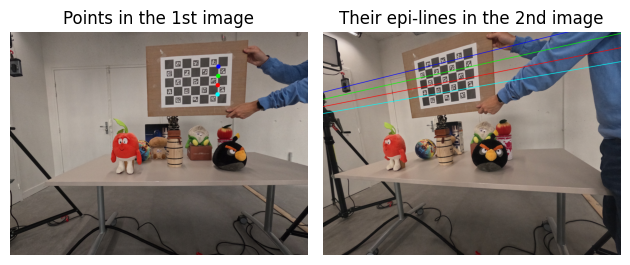

In [40]:
r_epilines = cv.computeCorrespondEpilines(l_corners, whichImage=1, F=l_F)

l_points = l_corners.reshape(-1, 2)
r_lines = r_epilines.reshape(-1, 3)
visualize_epipolar_lines(
    l_img_charuco, r_img_charuco, l_points[0:4, :], r_lines[0:4, :], radius=10, thickness=2)

We can do the same for points in the right image.

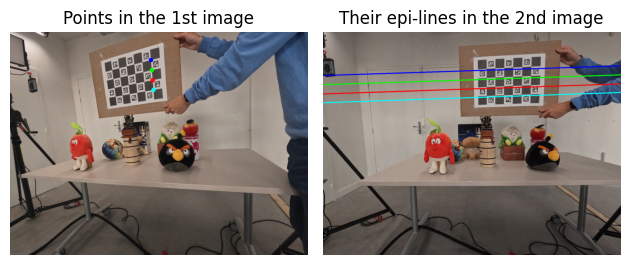

In [41]:
l_epilines = cv.computeCorrespondEpilines(r_corners, whichImage=2, F=l_F)

r_points = r_corners.reshape(-1, 2)
l_lines = l_epilines.reshape(-1, 3)
visualize_epipolar_lines(
    r_img_charuco, l_img_charuco, r_points[0:4, :], l_lines[0:4, :], radius=10, thickness=3)

### Visualize the relative pose

## Rectify a stereo system

In [42]:
l_rec_rotation, r_rec_rotation, l_rec_projection, r_rec_projection, l_Q, l_roi, r_roi = cv.stereoRectify(
    l_mtx, l_dist, r_mtx, r_dist, TARGET_SIZE, l_R, l_t)

print("Transform of the unrectified to the rectified first camera's frame:")
print(l_rec_rotation)
print("Transform of the unrectified to the rectified second camera's frame:")
print(r_rec_rotation)
print("Projection of the rectified points to the first camera's image:")
print(l_rec_projection)
print("Projection of the rectified points to the second camera's image:")
print(r_rec_projection)

Transform of the unrectified to the rectified first camera's frame:
[[ 0.9991914  -0.03888133  0.01023652]
 [ 0.03902999  0.99912921 -0.01474701]
 [-0.00965422  0.01513462  0.99983886]]
Transform of the unrectified to the rectified second camera's frame:
[[ 0.95909026 -0.04142984 -0.28005256]
 [ 0.04565365  0.99892054  0.00857285]
 [ 0.27939508 -0.02100756  0.95994639]]
Projection of the rectified points to the first camera's image:
[[562.49896158   0.         938.70111465   0.        ]
 [  0.         562.49896158 537.08613586   0.        ]
 [  0.           0.           1.           0.        ]]
Projection of the rectified points to the second camera's image:
[[ 562.49896158    0.          938.70111465 -344.67905709]
 [   0.          562.49896158  537.08613586    0.        ]
 [   0.            0.            1.            0.        ]]


In [43]:
r_map_1, r_map_2 = cv.initUndistortRectifyMap(
    r_mtx, r_dist, r_rec_rotation, r_rec_projection, TARGET_SIZE, cv.CV_32FC1)
l_map_1, l_map_2 = cv.initUndistortRectifyMap(
    l_mtx, l_dist, l_rec_rotation, l_rec_projection, TARGET_SIZE, cv.CV_32FC1)

In [47]:
l_img = cv.imread("forall/front/GOPR0158.JPG")
r_img = cv.imread("forall/right/GOPR0930.JPG")

l_img = cv.resize(l_img, TARGET_SIZE)
r_img = cv.resize(r_img, TARGET_SIZE)

l_img_rectified = cv.remap(l_img, l_map_1, l_map_2, cv.INTER_LINEAR)
r_img_rectified = cv.remap(r_img, r_map_1, r_map_2, cv.INTER_LINEAR)

In [170]:
l_rectified = np.flip(l_img_rectified, axis=2)
l_rectified.dtype

dtype('uint8')

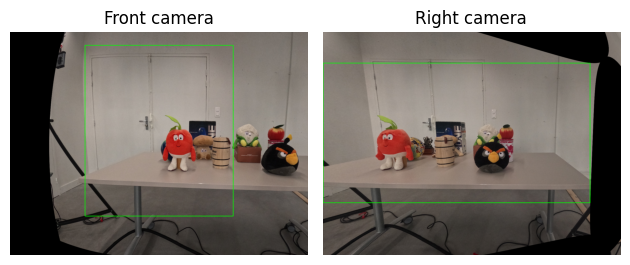

In [172]:
fig, axes = plt.subplots(1, 2)

# Display the images in the subplots
l_roi_rectified = np.copy(l_img_rectified)
cv.rectangle(l_roi_rectified, l_roi[:2], l_roi[2:], (0, 255, 0), 2)
axes[0].imshow(np.flip(l_roi_rectified, axis=2))
axes[0].set_title('Front camera')

r_roi_rectified = np.copy(r_img_rectified)
cv.rectangle(r_roi_rectified, r_roi[:2], r_roi[2:], (0, 255, 0), 2)
axes[1].imshow(np.flip(r_roi_rectified, axis=2))
axes[1].set_title('Right camera')

# Hide the axes
for ax in axes:
    ax.axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()

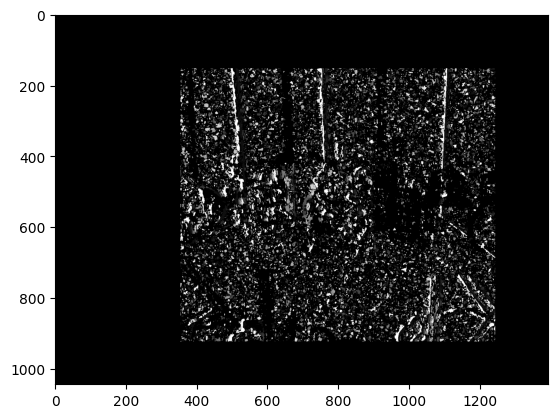

In [186]:
l_matcher = cv.StereoBM.create(numDisparities=16, blockSize=9)
r_matcher = cv.ximgproc.createRightMatcher(l_matcher)

l_matcher.setROI1(l_roi)
l_matcher.setROI2(r_roi)

# l_img_byte = cv.normalize(l_img_rectified, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)
# r_img_byte = cv.normalize(r_img_rectified, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)
l_img_gray = cv.cvtColor(l_img_rectified, cv.COLOR_BGR2GRAY)
r_img_gray = cv.cvtColor(r_img_rectified, cv.COLOR_BGR2GRAY)

l_disparity = l_matcher.compute(l_img_gray, r_img_gray)
r_disparity = r_matcher.compute(r_img_gray, l_img_gray)

plt.imshow(l_disparity, 'gray')

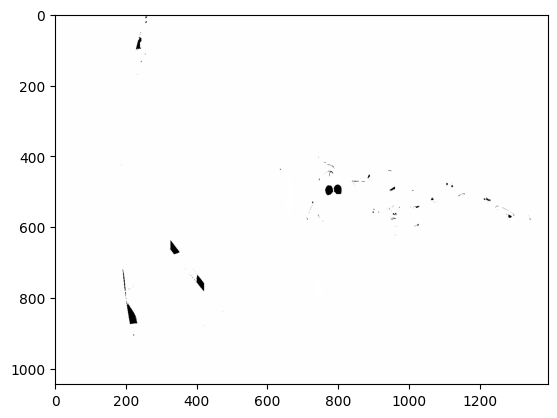

In [178]:
wls = cv.ximgproc.createDisparityWLSFilter(l_matcher)

f_disparity = wls.filter(l_disparity, l_img_rectified, disparity_map_right=r_disparity, right_view=r_img_rectified)
plt.imshow(f_disparity, 'gray')

In [214]:
min_disparity =  -1
max_disparity = 159
num_disparity = max_disparity - min_disparity
SADWindowSize = 5
uniqueness = 5
speckle_windows_size = 5
speckle_range = 5
P1 = 8 * 3 * SADWindowSize ** 2
P2 = 32 * 3 * SADWindowSize ** 2

l_matcher = cv.StereoSGBM_create(
    minDisparity=min_disparity,
    numDisparities=num_disparity,
    blockSize=SADWindowSize,
    P1=P1,
    P2=P2,
    uniquenessRatio=uniqueness,
    disp12MaxDiff=2,
    speckleWindowSize=speckle_windows_size,
    speckleRange=speckle_range
)
r_matcher = cv.ximgproc.createRightMatcher(l_matcher)

l_disparity = l_matcher.compute(l_img_rectified, r_img_rectified)
r_disparity = r_matcher.compute(r_img_rectified, l_img_rectified)

wsl = cv.ximgproc.createDisparityWLSFilter(l_matcher)
wsl.setLambda(8000)
wsl.setSigmaColor(1.5)
disparity = wsl.filter(l_disparity, l_img_rectified, disparity_map_right=r_disparity)

cv.filterSpeckles(disparity, 0, 400, max_disparity - 5)
_, disparity = cv.threshold(disparity, 0, max_disparity * 16, cv.THRESH_TOZERO)
# disparity = (disparity / 16).astype(np.uint8)

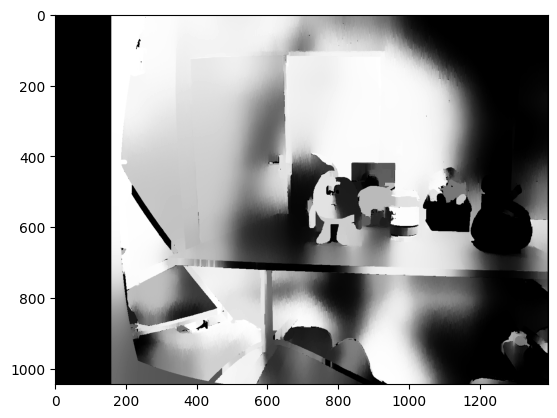

In [215]:
plt.imshow(disparity, 'gray')

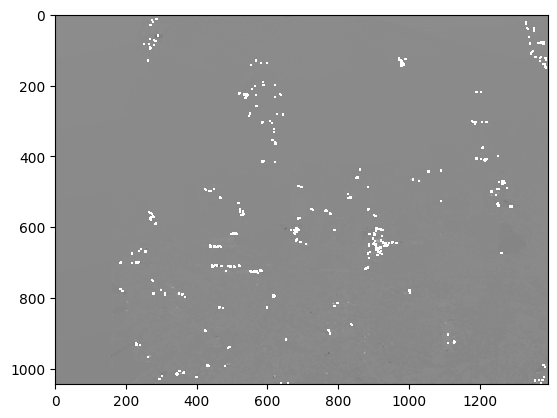

In [208]:
depth = cv.reprojectImageTo3D(l_disparity, l_Q)
plt.imshow(cv.cvtColor(depth, cv.COLOR_BGR2GRAY), 'gray')

In [141]:
import open3d as o3d

points = cv.reprojectImageTo3D(disparity, l_Q)
points = points.reshape(-1, 3)
colors = l_img_rectified.reshape(-1, 3)
colors = np.flip(colors, axis=1) / 255.

cloud = o3d.geometry.PointCloud()
cloud.points = o3d.utility.Vector3dVector(points)
cloud.colors = o3d.utility.Vector3dVector(colors)
o3d.io.write_point_cloud('cloud.ply', cloud)

True

In [152]:
l_Q

array([[   1.        ,    0.        ,    0.        , -938.70111465],
       [   0.        ,    1.        ,    0.        , -537.08613586],
       [   0.        ,    0.        ,    0.        ,  562.49896158],
       [   0.        ,    0.        ,    1.63194993,   -0.        ]])

## Dense correspondence

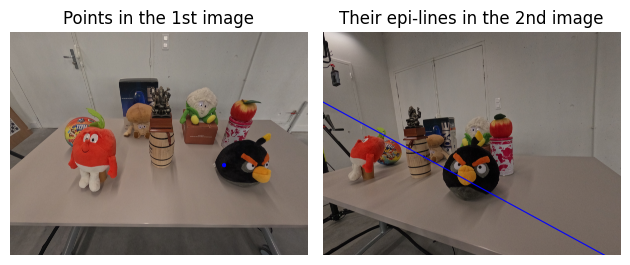

In [24]:
point = np.array([[4000, 2500]])
line = cv.computeCorrespondEpilines(np.expand_dims(point, axis=0), whichImage=2, F=r_F)
line = line.reshape(-1, 3)
visualize_epipolar_lines(l_img, r_img, point, line, radius=40)

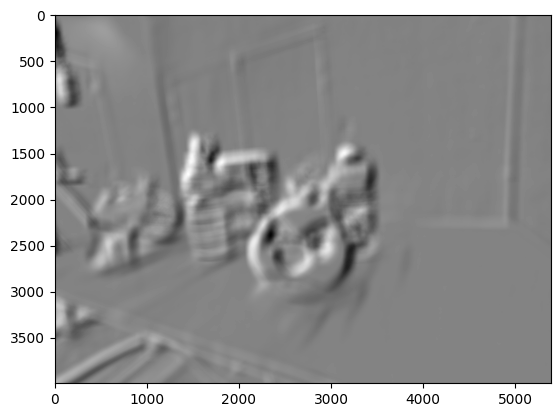

In [25]:
window = extract_window(l_img, point[0], (180, 180))
match_result = cv.matchTemplate(r_img, window, cv.TM_CCOEFF)
plt.imshow(match_result, 'gray')

In [26]:
np.max(match_result)

25270512.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.38942063..0.44132334].


(384, 512, 3)


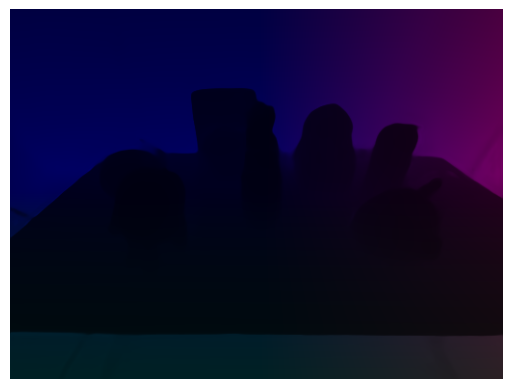

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
d = np.load("pts3d_0.npy")
print(d.shape)
plt.axis('off')
plt.imshow(d)